# Step 1:  Import a test Image to see if it works
```
VIS seems like it is a raw format (larger data shape and larger file size). There are also many more files in VIS. For these reasons I will use VIS not VIS_COR
What do M2 and M4 on VIS mean?
```

data shape: (315, 301, 224)


ImageView object:
  Display bands       :  [0, 112, 223]
  Interpolation       :  <default>
  RGB data limits     :
    R: [-0.1489362120628357, 0.6355420351028442]
    G: [0.0, 0.28161734342575073]
    B: [0.0, 0.9794167876243591]

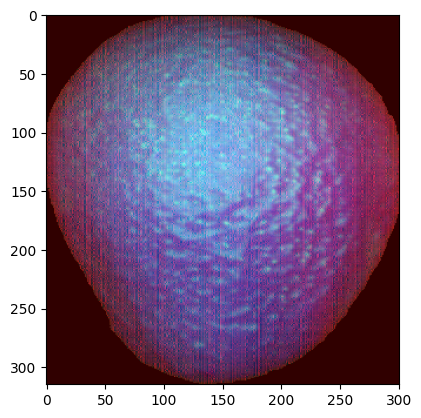

In [4]:
import spectral as sp
# NIR photo
# hdr = sp.envi.open('/Users/maycaj/Documents/Hyperspectral-Imaging/Avocado/NIR/day_01/avocado_day_01_01_back.hdr', image='/Users/maycaj/Documents/Hyperspectral-Imaging/Avocado/NIR/day_01/avocado_day_01_01_back.bin')

# VIS photo
hdr = sp.envi.open('/Users/maycaj/Documents/Hyperspectral-Imaging/Avocado/VIS/day_01/avocado_day_01_02_front.hdr', image='/Users/maycaj/Documents/Hyperspectral-Imaging/Avocado/VIS/day_01/avocado_day_01_02_front.bin')

# VIS_COR photo
# hdr = sp.envi.open('/Users/maycaj/Documents/Hyperspectral-Imaging/Avocado/VIS_COR/day_m4_01/avocado_day_m4_01_02_front.hdr', image='/Users/maycaj/Documents/Hyperspectral-Imaging/Avocado/VIS_COR/day_m4_01/avocado_day_m4_01_02_front.bin')

# Read the data from the HDR file
data = hdr.load()

# Visualize the hyperspectral image
print('data shape:', data.shape)
sp.imshow(data)

# ______ ask Karthik what he thinks about VIS vs VIS_COR

# Step 2: Display image in false RGB


ImageView object:
  Display bands       :  [0, 1, 2]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.28161734342575073]
    G: [0.0, 0.20407874882221222]
    B: [-0.0009101507603190839, 0.12427575141191483]

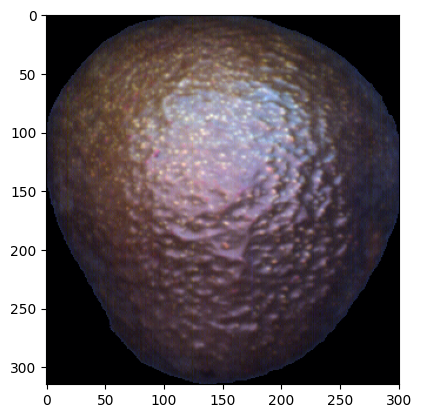

In [5]:
# Define the bands for false RGB
total_bands = 224 #from .hdr file
red_band = 112  
green_band = 46
blue_band = 28


# Create a false RGB image
false_rgb = data[:, :, [red_band, green_band, blue_band]]

# Visualize the false RGB image
sp.imshow(false_rgb)

# Step 4: Create a function that Oranizes the data into folders based on ripeness label
```
train_only_labelled_v2 seems to have the most annotations – will use that file one for now to pull my labells 
____ test other .json labells ```


In [8]:
import json
json_path = '/Users/maycaj/Documents/Hyperspectral-Imaging/Avocado/annotations/train_only_labeled_v2.json'

with open(json_path, 'r') as file:
    data = json.load(file)
print(data)

# Access the value of annotations -> 0 -> ripeness_State
ripeness_state_value = data['annotations'][0]['ripeness_state']
print("Ripeness State:", ripeness_state_value)


{'info': {'createdAt': '2022-09-14T15:08:36.894162'}, 'cameras': [{'id': 'VIS', 'name': 'Specim FX10', 'wavelengths': [397.66, 400.28, 402.9, 405.52, 408.13, 410.75, 413.37, 416.0, 418.62, 421.24, 423.86, 426.49, 429.12, 431.74, 434.37, 437.0, 439.63, 442.26, 444.89, 447.52, 450.16, 452.79, 455.43, 458.06, 460.7, 463.34, 465.98, 468.62, 471.26, 473.9, 476.54, 479.18, 481.83, 484.47, 487.12, 489.77, 492.42, 495.07, 497.72, 500.37, 503.02, 505.67, 508.32, 510.98, 513.63, 516.29, 518.95, 521.61, 524.27, 526.93, 529.59, 532.25, 534.91, 537.57, 540.24, 542.91, 545.57, 548.24, 550.91, 553.58, 556.25, 558.92, 561.59, 564.26, 566.94, 569.61, 572.29, 574.96, 577.64, 580.32, 583.0, 585.68, 588.36, 591.04, 593.73, 596.41, 599.1, 601.78, 604.47, 607.16, 609.85, 612.53, 615.23, 617.92, 620.61, 623.3, 626.0, 628.69, 631.39, 634.08, 636.78, 639.48, 642.18, 644.88, 647.58, 650.29, 652.99, 655.69, 658.4, 661.1, 663.81, 666.52, 669.23, 671.94, 674.65, 677.36, 680.07, 682.79, 685.5, 688.22, 690.93, 693.6

In [57]:
import numpy as np
from scipy.io import savemat

firmness_ripeness_list = []
# Define a funciton which pulls the ripeness_state, bin file, and hdr file from the json given the fruit_num
def get_RipenessWithPaths(fruit_num):
    json_path = '/Users/maycaj/Documents/Hyperspectral-Imaging/Avocado/annotations/train_only_labeled_v2.json'
    with open(json_path, 'r') as file:
        data = json.load(file)

    # access the .bin and .hdr filepaths
    bin = data['records'][fruit_num]['files']['data_file']
    hdr = data['records'][fruit_num]['files']['header_file']
    # add the location of the folder
    folder = '/Users/maycaj/Documents/Hyperspectral-Imaging/'
    bin = folder + bin
    hdr = folder + hdr

    # Access data within json file
    ripeness_state = data['annotations'][fruit_num]['ripeness_state']
    fruit = data['records'][fruit_num]['fruit']
    camera = data['records'][fruit_num]['camera_type']
    firmness = data['annotations'][fruit_num]['firmness']
    
    # If fruit is a papaya taken with the VIS camera – make & categorize mat file
    if fruit == 'Avocado':
        if camera == 'VIS':
            image = sp.envi.open(hdr, image=bin)
            # Read the data from the HDR file
            LoadedImage = image.load()

            # Save files to corresponding folders based on ripeness. Name files fruit_num.mat
            if ripeness_state == 'unripe':
                save_path = '/Users/maycaj/Documents/Hyperspectral-Imaging/Avocado/matlab/unripe'
                save_path = save_path + '/' + str(fruit_num) + '.mat'
            elif ripeness_state == 'perfect':
                save_path = '/Users/maycaj/Documents/Hyperspectral-Imaging/Avocado/matlab/perfect'
                save_path = save_path + '/' + str(fruit_num) + '.mat'
            elif ripeness_state == 'overripe':
                save_path = '/Users/maycaj/Documents/Hyperspectral-Imaging/Avocado/matlab/overripe'
                save_path = save_path + '/' + str(fruit_num) + '.mat'
            else:
                print(f"Something isn't right with the ripeness state ({ripeness_state})")
            
            # # Save files to corresponding folders based on firmness
            # if firmness <= 1000:
            #     save_path = '/Users/maycaj/Documents/Hyperspectral-Imaging/Avocado/matlab/soft'
            #     save_path = save_path + '/' + str(fruit_num) + '.mat'
            # elif firmness <= 1400:
            #     save_path = '/Users/maycaj/Documents/Hyperspectral-Imaging/Avocado/matlab/medium'
            #     save_path = save_path + '/' + str(fruit_num) + '.mat'
            # elif firmness <= 4500:
            #     save_path = '/Users/maycaj/Documents/Hyperspectral-Imaging/Avocado/matlab/hard'
            #     save_path = save_path + '/' + str(fruit_num) + '.mat'
            # else:
            #     print(f"Something isn't right with the firmness state ({firmness})")

            # Calculate the 224 bands evenly spaced from 400nm to 1000nm 
            bands = np.linspace(400,1000,224)
            data_to_save = {'hyperspectral_image': LoadedImage, 'headerfilepath': hdr, 'wavelength': bands}
            savemat(save_path, data_to_save)
            print(f'firmness: {firmness} Saving {ripeness_state} {fruit} from {bin} to {save_path}')
            
            # Make a list of the firmness of the Advocados so we can visualize
            firmness_ripeness_list.append([firmness, ripeness_state])

    return ripeness_state, bin, hdr, fruit, firmness

get_RipenessWithPaths(0)


('unripe',
 '/Users/maycaj/Documents/Hyperspectral-Imaging/Avocado/NIR/day_01/avocado_day_01_20_front.bin',
 '/Users/maycaj/Documents/Hyperspectral-Imaging/Avocado/NIR/day_01/avocado_day_01_20_front.hdr',
 'Avocado',
 19750)

# Step 6: Iterate over each item in the hyperspectral dataset & Visualize Firmness Distribution

In [58]:
for num in range(635):
    get_RipenessWithPaths(num)

# remove the none values from firmness_list
firmness_ripeness_list = [value for value in firmness_ripeness_list if value[0] is not None]
firmness_list = [value[0] for value in firmness_ripeness_list]
ripeness_list = [value[1] for value in firmness_ripeness_list]
ripeness_num = []
for value in ripeness_list:
    if value == 'unripe':
        ripeness_num.append(0)
    elif value == 'perfect':
        ripeness_num.append(1)
    elif value == 'overripe':
        ripeness_num.append(2)
    else:
        print('something not right with ripeness number')


FileNotFoundError: [Errno 2] No such file or directory: '/Users/maycaj/Documents/Hyperspectral-Imaging/Papaya/matlab/unripe/1.mat'

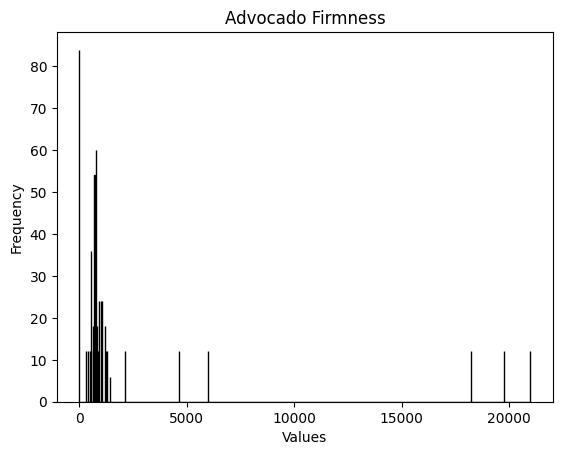

In [20]:
import matplotlib.pyplot as plt
plt.hist(firmness_list, bins=range(min(firmness_list), max(firmness_list)+1), edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Advocado Firmness')
plt.show()

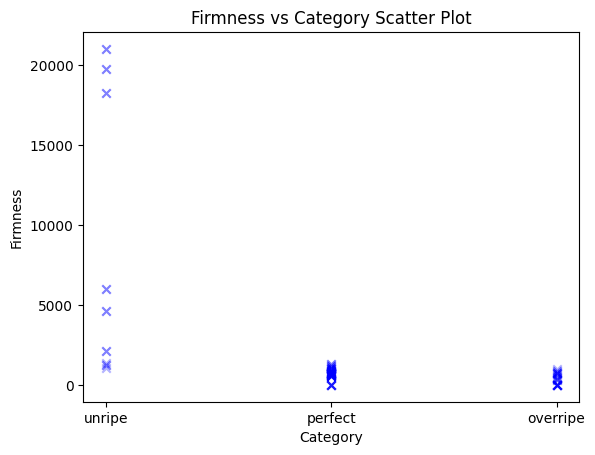

unripe: 128 occurrences
perfect: 400 occurrences
overripe: 184 occurrences


In [37]:
import matplotlib.pyplot as plt

#markers are mostly transparent so markers in the same place are a darker color
plt.scatter(ripeness_list, firmness_list, color='blue', marker='x', alpha=0.04)
plt.xlabel('Category')
plt.ylabel('Firmness')
plt.title('Firmness vs Category Scatter Plot')
plt.show()

from collections import Counter
# Count occurrences of each category
category_counts = Counter(ripeness_list)
for category, count in category_counts.items():
    print(f"{category}: {count} occurrences")

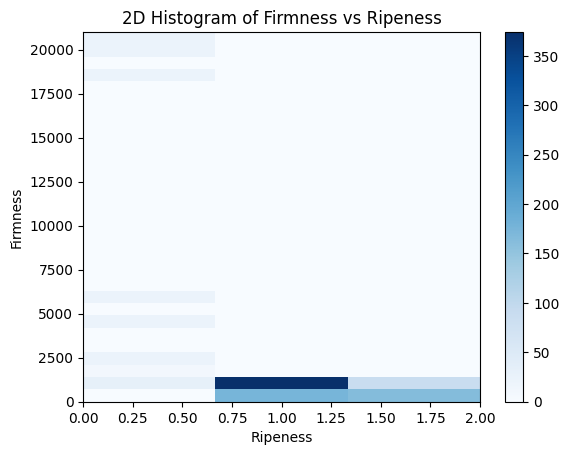

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2D histogram
plt.hist2d(ripeness_num, firmness_list, bins=(3, 30), cmap='Blues')
plt.colorbar()

plt.xlabel('Ripeness')
plt.ylabel('Firmness')
plt.title('2D Histogram of Firmness vs Ripeness')
plt.show()

```seems like most of the data hangs out right arround 2000 firmness – and it doesn't correlate super well with ripeness state```
```
The biggest insight is that perfect and overripe advocados will be right around 850-1500 but underripe advocados can be at either extreme (very firm or very soft)
```